<a href="https://colab.research.google.com/github/benheskins/Benedictheskins.github.io/blob/master/LegalDogsClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UFCFSN-15-3 - Artificial intelligence for creative technologies
Week 5




Benedict Heskins

17022914

https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971

https://www.youtube.com/watch?v=n4mxwSAWvo8

In [ ]:
import os
import cv2
import tensorflow as tf
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

import tensorflow_hub as hub
import tensorflow_datasets as tfds

import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)


In [ ]:

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fid = drive.ListFile({'q':"title='dogs_dataset.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('dogs_dataset.zip')
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

In [ ]:
!unzip dogs_dataset.zip

Archive:  dogs_dataset.zip
replace dogs_dataset/test/illegal/american-bulldog-breed-pictures-1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:

class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()


batch_stats_callback = CollectBatchStats()






In [ ]:
PATH = 'dogs_dataset'

In [ ]:
os.listdir(PATH)


['train', 'test']

In [ ]:
train_dir = os.path.join(PATH,'train')
test_dir = os.path.join(PATH, 'test')

In [ ]:
train_legal_dir = os.path.join(train_dir,
                                'legal')
train_illegal_dir = os.path.join(train_dir,
                                   'illegal')

test_legal_dir = os.path.join(test_dir,
                               'legal')
test_illegal_dir = os.path.join(test_dir,
                                  'illegal')


In [ ]:
total_train = len(os.listdir(train_illegal_dir)) + len(os.listdir(train_legal_dir))
total_test = len(os.listdir(test_illegal_dir)) + len(os.listdir(test_legal_dir))

In [ ]:
print('total training illegal dog images:', len(os.listdir(train_illegal_dir)))
print('total training legal dog images:', len(os.listdir(train_legal_dir)))

print('total test illegal dog images:', len(os.listdir(test_illegal_dir)))
print('total test legal dog images:', len(os.listdir(test_legal_dir)))
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_test)

total training illegal dog images: 587
total training legal dog images: 693
total test illegal dog images: 64
total test legal dog images: 75
--
Total training images: 1280
Total validation images: 139


In [ ]:
# configuration
image_width = 224
image_height = 224
batch_size = 32
epochs = 6


# variables
num_classes = 0
dataset = []
labels = []


In [ ]:

# training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(image_height, image_width),
    batch_size=batch_size)


# validation dataset (used during training)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(image_height, image_height),
    batch_size=batch_size)

Found 1280 files belonging to 2 classes.
Found 139 files belonging to 2 classes.


In [ ]:
# load class names
class_names = np.array(train_ds.class_names)
num_classes = len(class_names)


# show example images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [ ]:


# data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])


# normalization layer
normalization_layer = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(image_height, image_width),
    tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)
])


# prepare training dataset
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=AUTOTUNE)


# normalize validation and test datasets
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))



 Transfer learning

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(image_width, image_height, 3))

In [ ]:
feature_extractor.trainable = False

## Training the model

In [ ]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2)
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
num_legal_train = len(os.listdir(train_legal_dir))
num_illegal_train = len(os.listdir(train_illegal_dir))


num_legal_test = len(os.listdir(test_legal_dir))
num_illegal_test = len(os.listdir(test_illegal_dir))


total_train = num_legal_train + num_illegal_train 
total_test = num_legal_test + num_illegal_test 

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


In [ ]:

history = model.fit(train_ds, epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[batch_stats_callback])



Epoch 1/6
40/40 [==============================] - 74s 2s/step - loss: 0.4287 - acc: 0.8003 - val_loss: 0.2087 - val_acc: 0.9424
Epoch 2/6
40/40 [==============================] - 70s 2s/step - loss: 0.2367 - acc: 0.9055 - val_loss: 0.1794 - val_acc: 0.9424
Epoch 3/6
40/40 [==============================] - 70s 2s/step - loss: 0.2173 - acc: 0.9131 - val_loss: 0.2119 - val_acc: 0.9353
Epoch 4/6
40/40 [==============================] - 72s 2s/step - loss: 0.1767 - acc: 0.9291 - val_loss: 0.1955 - val_acc: 0.9424
Epoch 5/6
40/40 [==============================] - 71s 2s/step - loss: 0.1689 - acc: 0.9314 - val_loss: 0.1792 - val_acc: 0.9496
Epoch 6/6
40/40 [==============================] - 72s 2s/step - loss: 0.1697 - acc: 0.9314 - val_loss: 0.1868 - val_acc: 0.9568


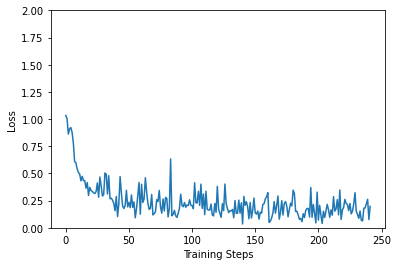

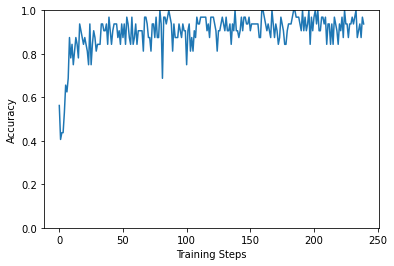

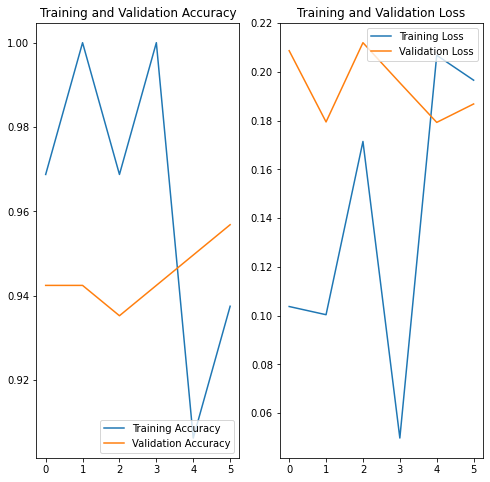

In [ ]:


# Plot batch metrics
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0, 2])
plt.plot(batch_stats_callback.batch_losses)
plt.show()

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0, 1])
plt.plot(batch_stats_callback.batch_acc)
plt.show()


# plot the training history
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(test_data_gen, steps=math.ceil(total_test/32))
print('Accuracy on test dataset:', test_accuracy)